## Load sample data

In [1]:
import tensorflow as tf
# disable warnings and enhance performance
tf.compat.v1.disable_eager_execution()  

import json
with open('qm9_sample.json', 'r') as f:
    data = json.load(f)

In [5]:
data.keys()

dict_keys(['116432', '9942', '52186', '71582', '113708', '77390', '102301', '100796', '48256', '110481', '104813', '86051', '52942', '33289', '75885', '44882', '105660', '38292', '34271', '86040', '985', '51163', '124191', '113585', '125258', '125736', '112154', '128762', '71180', '118242', '90982', '83363', '15301', '90742', '72726', '57620', '20782', '114102', '111491', '133718', '19276', '80181', '25429', '130395', '104903', '2664', '87058', '124997', '42358', '37596', '60039', '21270', '129827', '107045', '90958', '37672', '12388', '89600', '4257', '12596', '49881', '124481', '74191', '123986', '27484', '119789', '35399', '25489', '53392', '99416', '113135', '79731', '123458', '67989', '19247', '46941', '79572', '112089', '81679', '120581', '56283', '115913', '4084', '88546', '81340', '43456', '108816', '52636', '91907', '78555', '10270', '100190', '83839', '121803', '19804', '123932', '84846', '57683', '127158', '65897'])

In [7]:
data['116432'].keys()

dict_keys(['molecule', 'property', 'smiles'])

In [8]:
data['116432']['molecule']

{'@module': 'pymatgen.core.structure',
 '@class': 'Molecule',
 'charge': 0,
 'spin_multiplicity': 1,
 'sites': [{'name': 'O',
   'species': [{'element': 'O', 'occu': 1}],
   'xyz': [-0.0144247674, 1.4176749803, -0.0676474999],
   'properties': {}},
  {'name': 'C',
   'species': [{'element': 'C', 'occu': 1}],
   'xyz': [0.0523419666, 0.0081529066, -0.004018499],
   'properties': {}},
  {'name': 'C',
   'species': [{'element': 'C', 'occu': 1}],
   'xyz': [-1.3447622868, -0.6007986394, 0.0166315394],
   'properties': {}},
  {'name': 'O',
   'species': [{'element': 'O', 'occu': 1}],
   'xyz': [-1.9954504103, -0.1582217063, -1.1756489358],
   'properties': {}},
  {'name': 'C',
   'species': [{'element': 'C', 'occu': 1}],
   'xyz': [-3.3306278386, -0.6214923899, -1.3024586091],
   'properties': {}},
  {'name': 'C',
   'species': [{'element': 'C', 'occu': 1}],
   'xyz': [-3.3595079389, -2.1419737241, -1.4374898138],
   'properties': {}},
  {'name': 'C',
   'species': [{'element': 'C', 'occu':

In [9]:
data['116432']['property']

{'tag': 'gdb',
 'index': 116432.0,
 'A': 2.43225,
 'B': 1.4003,
 'C': 0.93986,
 'mu': 3.9213,
 'alpha': 71.78,
 'homo': -6.48175548,
 'lumo': -0.7591980600000001,
 'gap': 5.72255742,
 'r2': 1237.8988,
 'zpve': 4.3433203996000005,
 'U0': -79.0410352142011,
 'U': -79.53715345899988,
 'H': -79.99980168180117,
 'G': -73.46365061320068,
 'Cv': 32.459,
 'omega1': 3796.7514}

## Process train_structures and train_targets

In [11]:
# from pymatgen import Molecule
from pymatgen.core.structure import Molecule

qm9_ids = list(data.keys())

molecules = [Molecule.from_dict(data[i]['molecule']) for i in qm9_ids]  # this gives a list of pymatgen Molecule

structures = molecules
targets = [data[i]['property']['U0'] for i in qm9_ids]  # We are training U0 here


## Data splits

In reality, use train-val-test splits. Validation split can be used to select hyperparameters (e.g., epochs)

In [12]:
train_structures = structures[:80]
test_structures = structures[80:]
train_targets = targets[:80]
test_targets = targets[80:]

## Construct megnet models

In [13]:
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.utils.preprocessing import StandardScaler
import numpy as np

In [14]:
gc = CrystalGraph(bond_converter=GaussianDistance(
    np.linspace(0, 5, 100), 0.5), cutoff=4)
model = MEGNetModel(100, 2, graph_converter=gc)

### Scale targets to train per atom quantity 

In [15]:
INTENSIVE = False # U0 is an extensive quantity
scaler = StandardScaler.from_training_data(train_structures, train_targets, is_intensive=INTENSIVE)
model.target_scaler = scaler

In [16]:
scaler

StandardScaler(mean=-4.259, std=0.188, is_intensive=False)

## Train the model!

In [18]:
model.train(train_structures, train_targets, epochs=100, verbose=2)  # In reality, use epochs>1000

Epoch 1/100
1/1 - 0s - loss: 0.9533 - 72ms/epoch - 72ms/step
Epoch 2/100
1/1 - 0s - loss: 0.9407 - 104ms/epoch - 104ms/step
Epoch 3/100
1/1 - 0s - loss: 0.9239 - 98ms/epoch - 98ms/step
Epoch 4/100
1/1 - 0s - loss: 0.9004 - 101ms/epoch - 101ms/step
Epoch 5/100
1/1 - 0s - loss: 0.8687 - 96ms/epoch - 96ms/step
Epoch 6/100
1/1 - 0s - loss: 0.8237 - 106ms/epoch - 106ms/step
Epoch 7/100
1/1 - 0s - loss: 0.7693 - 93ms/epoch - 93ms/step
Epoch 8/100
1/1 - 0s - loss: 0.7317 - 107ms/epoch - 107ms/step
Epoch 9/100
1/1 - 0s - loss: 0.8259 - 99ms/epoch - 99ms/step
Epoch 10/100
1/1 - 0s - loss: 0.8171 - 103ms/epoch - 103ms/step
Epoch 11/100
1/1 - 0s - loss: 0.7401 - 97ms/epoch - 97ms/step
Epoch 12/100
1/1 - 0s - loss: 0.7142 - 99ms/epoch - 99ms/step
Epoch 13/100
1/1 - 0s - loss: 0.7320 - 102ms/epoch - 102ms/step
Epoch 14/100
1/1 - 0s - loss: 0.7274 - 97ms/epoch - 97ms/step
Epoch 15/100
1/1 - 0s - loss: 0.7201 - 107ms/epoch - 107ms/step
Epoch 16/100
1/1 - 0s - loss: 0.7230 - 94ms/epoch - 94ms/step
Epo

## Predict test data

In [19]:
predicted_tests = []
for i in test_structures:
    predicted_tests.append(model.predict_structure(i).ravel()[0])

/root/anaconda3/envs/megnet/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Text(0, 0.5, 'Predicted $U_0$ (eV)')

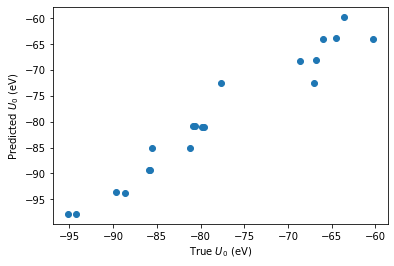

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(test_targets, predicted_tests, 'o')
plt.xlabel('True $U_0$ (eV)')
plt.ylabel('Predicted $U_0$ (eV)')

Text(0, 0.5, 'Predicted $U_0$ (eV)')

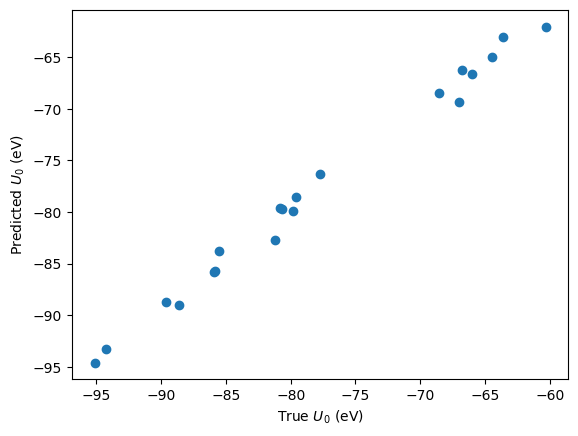

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(test_targets, predicted_tests, 'o')
plt.xlabel('True $U_0$ (eV)')
plt.ylabel('Predicted $U_0$ (eV)')

Results seem to be good considering that we are using 80 data points to train the model!